In [1]:
import os
import cycledata as cd
import pandas as pd
import numpy as np
import gc
import seaborn
import matplotlib.pylab as plt
import statsmodels.graphics.tsaplots
from statsmodels.tsa.stattools import acf, pacf, adfuller
import rpy2.robjects.packages as rpackages 
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.seasonal import seasonal_decompose
# import statsmodels.tsa.arima_process
%matplotlib inline
%load_ext rpy2.ipython
pandas2ri.activate()

# R package names
packnames = ('forecast')
if all(rpackages.isinstalled(x) for x in packnames):
    have_tutorial_packages = True
else:
    have_tutorial_packages = False
    
if not have_tutorial_packages:
    # import R's utility package
    utils = rpackages.importr('utils')
    # select a mirror for R packages
    utils.chooseCRANmirror(ind=1) # select the first mirror in the list

if not have_tutorial_packages:
    # R vector of strings
    from rpy2.robjects.vectors import StrVector
    # file
    packnames_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
    if len(packnames_to_install) > 0:
        utils.install_packages(StrVector(packnames_to_install))
        
# Import R packages
forecast = importr('forecast')
base = importr('base')

def ts(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window,center=False).mean()
    rolstd = timeseries.rolling(window=window,center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(111)
    plt.legend(loc='best')
    ttl = 'Rolling Mean & Standard Deviation'
    plt.title(ttl, fontsize=22)
    
    ax.xaxis.set_label_position('bottom')
    xlab = 'Date Index in 30 Minute Intervals'
    ax.set_xlabel(xlab, fontsize=16, ha='left')
    ax.xaxis.set_label_coords(0.37, -0.05)
    ylab = 'Count Difference '
    ax.set_ylabel(ylab, fontsize=16, ha='left')
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='RollingMean')
    std = plt.plot(rolstd, color='black', label = 'RollingStd')
    plt.savefig('DickyFuller.png', bbox_inches='tight', dpi=300)
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.ix[:,0], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [2]:
# Import Full Years (non-seperated weeks)
FullYear = {}
FullYear = cd.Import('fullyear')
year15 = FullYear['2015'].copy()
year15.sort_values('s_date', inplace=True)
year15.set_index(year15.s_date, drop=True, inplace=True)
DF = year15[:'18-12-2015'].copy()
# Find nearest Sunday
j = 1
while(int(DF[-j:(len(DF) - j + 1)].index.dayofweek) != 6):
    j += 1
DF = DF[:(-j+1)]
# 4 week section of 2015 to be used for modelling an validation
recent = DF.last('4W')
# 10 weekends section of 2015 to be used for modelling and validation
recentWE = DF.last('5W')

Reading: 2012FullYear.csv
Reading: 2013FullYear.csv
Reading: 2014FullYear.csv
Reading: 2015FullYear.csv
Reading: 2016FullYear.csv


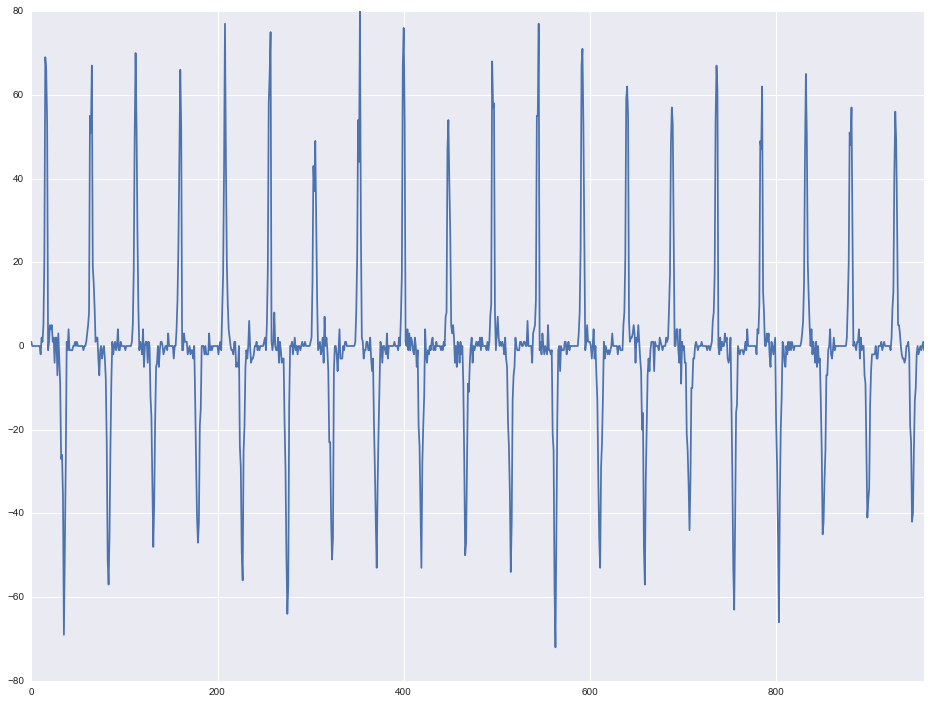

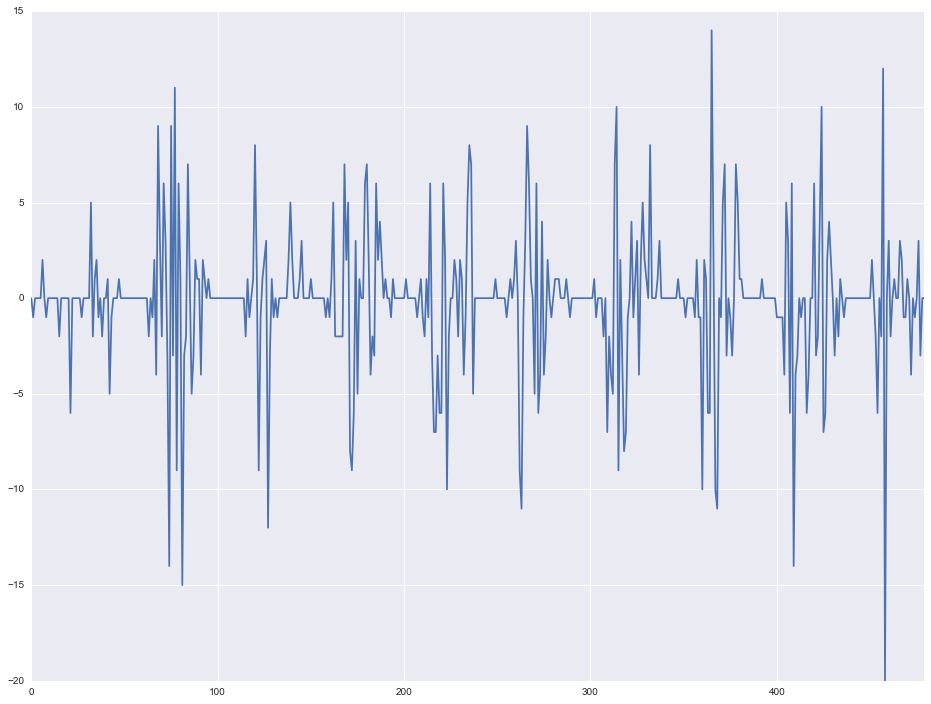

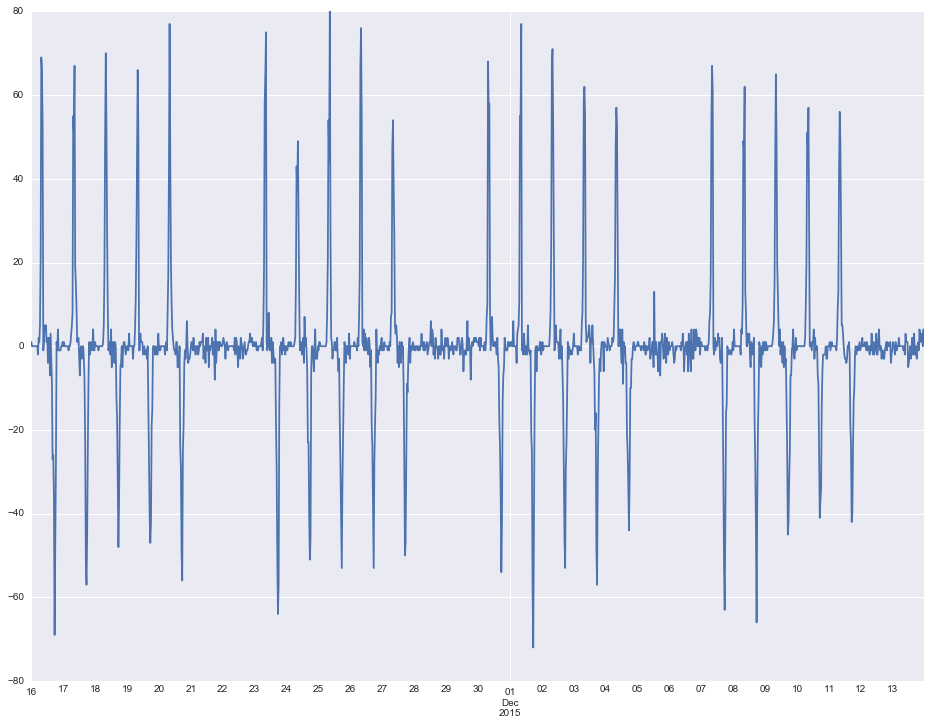

In [3]:
# Plot FullSeries, Weekdays, Weekends
WDModel = cd.Model(recent, 14)
WDModel.PreProcess(separate=True)
WDModel.WD.reset_index(inplace=True, drop=True)
WDModel.WD = WDModel.WD[:(48*5*4)]
WDModel.WD.plot(figsize=(16,12), legend=False)

WEModel = cd.Model(recentWE, 191)
WEModel.PreProcess(separate=True)
WEModel.WE.reset_index(inplace=True, drop=True)
WEModel.WE = WEModel.WE[:48*10]
WEModel.WE.plot(figsize=(16,12), legend=False)

Model = cd.Model(recent, 14)
Model.PreProcess(separate=False)
Model.Full[:(48*7*4)].plot(figsize=(16,12), legend=False)

In [97]:
# Validating Weekday Model/Determing forecast length
RMSE = []
MAE = []
EFrame = pd.DataFrame(index=range(1,5), columns=['MAE', 'RMSE'])
# i: Number of days in Forecast 
for i in range(1, 5):
    WDModel = cd.Model(recent, 14)
    WDModel.PreProcess(separate=True)
    forecast = 48*i
    training = WDModel.WD[:-forecast]
    test = WDModel.WD[-forecast:]
    # No jump needed
    WD_dates = training.index
    y = np.asarray(WD_dates[-1].year, dtype='datetime64[Y]') - 1970
    doy = np.asarray((WD_dates[-1].dayofyear + 1), dtype='timedelta64[D]') - 1
    new = pd.to_datetime(y + doy)
    new_dates = pd.DatetimeIndex(start=new, freq='30Min', periods=48 * 4)
    training.reset_index(inplace=True, drop=True)
    gc.collect()
    robjects.r('o = c(2,0,1)')
    robjects.r('sorder = c(1,1,2)')
    robjects.r('s = list(order=sorder, period=48)')
    DF = pandas2ri.py2ri(training)
    robjects.r.assign('df', DF)
    robjects.r('fit = Arima(df,order=o, seasonal=s, method="CSS")')
    f_cast = robjects.r('f_cast = forecast(fit, h=4*48)')
    arima_mean = np.array(f_cast.rx('mean'))
    robjects.r('rm(list = ls(all = TRUE))')
    robjects.r('gc()')
    results = pd.DataFrame({'count_diff':
    arima_mean.flatten()}).round()
    results.count_diff = results.count_diff.astype(int)
    results['DateTime'] = new_dates
    del f_cast
    del DF
    gc.collect()
    results.set_index('DateTime', inplace=True, drop=True)
    del results.index.name
    # Calculate Mean Squared Errors
    Errors = pd.Series(test.count_diff - results.count_diff)
    SqErrors = Errors.apply(lambda y: y**2)
    absError = Errors.apply(lambda y: np.abs(y))
    if ~np.isnan(SqErrors.mean()):
        mse = SqErrors.mean()
        RMSE.append(np.sqrt(mse))
    MAE.append(absError.mean())
EFrame['MAE'] = MAE
EFrame['RMSE'] = RMSE
EFrame

,MAE,RMSE
1,2.520833,4.225419
2,3.281250,5.913438
3,2.527778,4.512329
4,2.583333,4.342138


In [109]:
# Validating Weekend model
WEModel = cd.Model(recentWE, 191)
WEModel.PreProcess(separate=True)
WEModel.WE = WEModel.WE[:10*48]
forecast = 48*2
training = WEModel.WE[:-forecast]
test = WEModel.WE[-forecast:]
WE_dates = training.index
y = np.asarray(WE_dates[-1].year, dtype='datetime64[Y]') - 1970
doy = np.asarray((WE_dates[-1].dayofyear + 1), dtype='timedelta64[D]') - 1
new = pd.to_datetime(y + doy)
new_dates = pd.DatetimeIndex(start=new, freq='30Min', periods=48*2)
training.reset_index(inplace=True, drop=True)
gc.collect()
robjects.r('o = c(0,0,0)')
robjects.r('sorder = c(0,1,0)')
robjects.r('s = list(order=sorder, period=18)')
DF = pandas2ri.py2ri(training)
robjects.r.assign('df', DF)
robjects.r('fit = Arima(df,order=o, seasonal=s, method="CSS")')
f_cast = robjects.r('f_cast = forecast(fit, h=2*48)')
arima_mean = np.array(f_cast.rx('mean'))
robjects.r('rm(list = ls(all = TRUE))')
robjects.r('gc()')
results = pd.DataFrame({'count_diff':
arima_mean.flatten()}).round()
results.count_diff = results.count_diff.astype(int)
results['DateTime'] = new_dates
del f_cast
del DF
gc.collect()
results.set_index('DateTime', inplace=True, drop=True)
del results.index.name
# Calculate Mean Squared Errors
mae = 0
rmse = 0
Errors = pd.Series(test.count_diff.values - results.count_diff.values)
SqErrors = Errors.apply(lambda y: y**2)
absError = Errors.apply(lambda y: np.abs(y))
if ~np.isnan(SqErrors.mean()):
    mse = SqErrors.mean()
    rmse = np.sqrt(mse)
    mae = absError.mean()
print(mae, rmse)

4.40625 5.94681287189


In [111]:
# Test Historic Values as Predictor (Previous Weekend)
test = WEModel.WE[-48*2:].reset_index(drop=True)
historicPredictors = WEModel.WE[-48*4:-48*2].reset_index(drop=True)
Errors = pd.Series(test.count_diff - historicPredictors.count_diff)
SqErrors = Errors.apply(lambda y: y**2)
absError = Errors.apply(lambda y: np.abs(y))
if ~np.isnan(SqErrors.mean()):
    mse = SqErrors.mean()
    RMSE = np.sqrt(mse)
    MAE = absError.mean()
print(MAE,RMSE)

3.3229166666666665 5.52739390069


In [112]:
# Test Historic Values as Predictor (Previous 4 Weekdays)
test = WDModel.WD[-48*4:].reset_index(drop=True)
historicPredictors = WDModel.WD[-48*8:-48*4].reset_index(drop=True)
Errors = pd.Series(test.count_diff - historicPredictors.count_diff)
SqErrors = Errors.apply(lambda y: y**2)
absError = Errors.apply(lambda y: np.abs(y))
if ~np.isnan(SqErrors.mean()):
    mse = SqErrors.mean()
    RMSE = np.sqrt(mse)
    MAE = absError.mean()
print(MAE,RMSE)

3.5416666666666665 5.80947501931


In [151]:
# Calculate errors of Weekend Models
ErrorFrame = pd.DataFrame(index=cd.station_range, columns=['MAE', 'RMSE'])
done = False
out = pd.DataFrame()
output = pd.DataFrame()
for x in cd.station_range:
    SepModel = cd.Model(recent, x)
    if SepModel.valid is False:
        absent.append(x)
        continue
    SepModel.PreProcess(separate=True)
    # Ensure series length is only 4 Weeks
    SepModel.WD = SepModel.WD[:20 * 48]
    forecast = 48*4
    training = SepModel.WD[:-forecast].copy()
    test = SepModel.WD[-forecast:].copy()
    if(len(training) > 0):
        if done is False:  # Only needs to be run once
            done = True
            WD_dates = training.index
            y = np.asarray(WD_dates[-1].year, dtype='datetime64[Y]') - 1970
            doy = np.asarray((WD_dates[-1].dayofyear)+1, dtype='timedelta64[D]') - 1
            new = pd.to_datetime(y + doy)
            new_dates = pd.DatetimeIndex(start=new, freq='30Min', periods=48 * 4)
        training.reset_index(inplace=True, drop=True)
        gc.collect()
        robjects.r('o = c(2,0,1)')
        robjects.r('sorder = c(1,1,2)')
        robjects.r('s = list(order=sorder, period=48)')
        DF = pandas2ri.py2ri(training)
        robjects.r.assign('df', DF)
        try:
            robjects.r('fit = Arima(df,order=o, seasonal=s, method="CSS")')
        except:
            errors.append(x)
            continue
        f_cast = robjects.r('f_cast = forecast(fit, h=4*48)')
        arima_mean = np.array(f_cast.rx('mean'))
        robjects.r('rm(list = ls(all = TRUE))')
        robjects.r('gc()')
        results = pd.DataFrame({'count_diff': arima_mean.flatten()}).round()
        results.count_diff = results.count_diff.astype(int)
        results['DateTime'] = new_dates
        results['Type'] = 'Forecast'
        results['ID'] = x
        training['DateTime'] = WD_dates
        training['Type'] = 'Historic'
        training['ID'] = x
        out = training.append(results)
        output = output.append(out)
        # Calculate Mean Squared Errors
        Errors = pd.Series(test.count_diff.values - results.count_diff.values)
        SqErrors = Errors.apply(lambda y: y**2)
        absError = Errors.apply(lambda y: np.abs(y))
        if ~np.isnan(SqErrors.mean()):
            mse = SqErrors.mean()
            ErrorFrame.loc[x, 'RMSE'] = np.sqrt(mse)
        ErrorFrame.loc[x, 'MAE'] = absError.mean()
        del f_cast
        del DF
        del results
        del training
        del SepModel
        gc.collect()
output.ID = output.ID.astype(int)
output.count_diff = output.count_diff.astype(int)
output.reset_index(inplace=True, drop=True)
path = cd.wd + '\Model'
if not os.path.exists(path):
    os.mkdir(path)
output.to_csv(path + '\\' 'WDModelOutput.csv')
ErrorFrame.dropna(inplace=True)
ErrorFrame.to_csv(path + '\\' + 'ModelsErrors.csv')

In [29]:
ErrorFrame = pd.read_csv(cd.wd + '\Model\ModelsErrors.csv', index_col=0)
adj = ErrorFrame.reset_index()
adj.rename(columns={'index':'ID'}, inplace=True)
row = (adj.ID == 710) | (adj.ID == 724)
bad_index = adj.loc[row,:].copy()
adjusted = ErrorFrame.drop(ErrorFrame.index[[bad_index.index[0], bad_index.index[1]]])
adjusted.describe()

,MAE,RMSE
count,738.000000,738.000000
mean,0.720726,1.216185
std,0.354982,0.609100
min,0.000000,0.000000
25%,0.505208,0.899218
50%,0.692708,1.141089
75%,0.889323,1.425674
max,3.354167,7.920832
